# Are signal lags necessary to explain the Doppler oscillations?

Necessity is tested by replacing the light-time lags by a constant. The m/s units enforced in `OrbitFitter.fit_doppler_data` are ensured by applying the lag computed at the first sample epoch to all sample epochs. The result is a slope instead of a steady oscillation, proving that the lag needs to be range proportional. 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, find_swings

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + 30*u.day

In [2]:
sampling_interval = 3600
sample_offsets = np.arange(0, (canberra_end-canberra_start)/(1*u.s), sampling_interval)
flyby_epochs = canberra_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]


In [3]:
near_goldstone_ephem = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR)
near_goldstone_end_rv = near_goldstone_ephem.rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_extended_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 17847093.095720734 km
Start and end radial speeds: 7.3216176182785535 km / s 6.742051287016325 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
sim_meas = []
first_ref_ra = None

for e in flyby_epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = dss34.range_rate_accel(rv, e)
    if first_ref_ra is None:
            first_ref_ra = ref_ra
    sim_meas.append([ref_rr - 0.1*first_ref_ra*ref_r/const.c])

print(sim_meas)

[[<Quantity 7.32161944 km / s>], [<Quantity 7.18773941 km / s>], [<Quantity 7.10047313 km / s>], [<Quantity 7.04518389 km / s>], [<Quantity 7.0132172 km / s>], [<Quantity 6.99897341 km / s>], [<Quantity 6.99823283 km / s>], [<Quantity 7.00738547 km / s>], [<Quantity 7.02311267 km / s>], [<Quantity 7.04229482 km / s>], [<Quantity 7.06203331 km / s>], [<Quantity 7.07972644 km / s>], [<Quantity 7.09316362 km / s>], [<Quantity 7.1006154 km / s>], [<Quantity 7.10090473 km / s>], [<Quantity 7.09345034 km / s>], [<Quantity 7.0782775 km / s>], [<Quantity 7.0559943 km / s>], [<Quantity 7.02773451 km / s>], [<Quantity 6.99507013 km / s>], [<Quantity 6.95989848 km / s>], [<Quantity 6.92431019 km / s>], [<Quantity 6.8904457 km / s>], [<Quantity 6.86034873 km / s>], [<Quantity 6.83582578 km / s>], [<Quantity 6.81832058 km / s>], [<Quantity 6.80881235 km / s>], [<Quantity 6.80774502 km / s>], [<Quantity 6.81499318 km / s>], [<Quantity 6.82986779 km / s>], [<Quantity 6.85116203 km / s>], [<Quantity 6

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, [dss34], var=0.001, debug=True)

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_doppler_data(flyby_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss34)

-1. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
4. 6.892909 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 

In [8]:
print(fitter.result.residual)

[ 0.02641811  0.01775769  0.01021431  0.00488936  0.00118125 -0.00138128
 -0.0030972  -0.00416471 -0.00473043 -0.00491643 -0.00483363 -0.00458736
 -0.00427841 -0.00400159 -0.00384299 -0.00387682 -0.00416225 -0.00474062
 -0.0056335  -0.00684148 -0.00834413 -0.01010103 -0.012054   -0.01413046
 -0.01624782 -0.01831868 -0.0202566  -0.02198193 -0.02342748 -0.02454339
 -0.02530089 -0.0256946  -0.02574312 -0.02548792 -0.02499052 -0.02432826
 -0.023589   -0.02286516 -0.02224752 -0.02181923 -0.02165044 -0.02179387
 -0.02228142 -0.0231223  -0.02430244 -0.02578538 -0.02751463 -0.02941723
 -0.03140845 -0.0333973  -0.03529258 -0.03700895 -0.03847285 -0.03962756
 -0.04043723 -0.04088945 -0.04099619 -0.04079301 -0.04033656 -0.03970067
 -0.03897114 -0.03823985 -0.03759848 -0.03713222 -0.0369142  -0.03700056
 -0.03742685 -0.03820572 -0.03932619 -0.04075435 -0.04243563 -0.04429838
 -0.04625863 -0.04822565 -0.05010802 -0.05181986 -0.0532867  -0.05445063
 -0.05527437 -0.0557439  -0.05586947 -0.05568495 -0

The slope in the result suggests trajectory divergence from the constant lag.

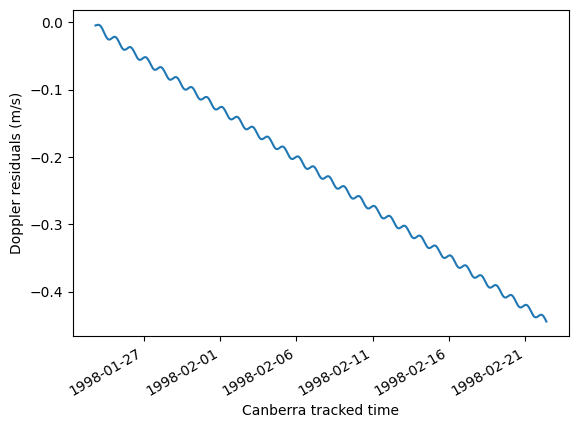

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy import visualization
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Canberra tracked time')
    plt.ylabel('Doppler residuals (m/s)')
    plt.plot(flyby_epochs[10:], fitter.result.residual[10:])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()

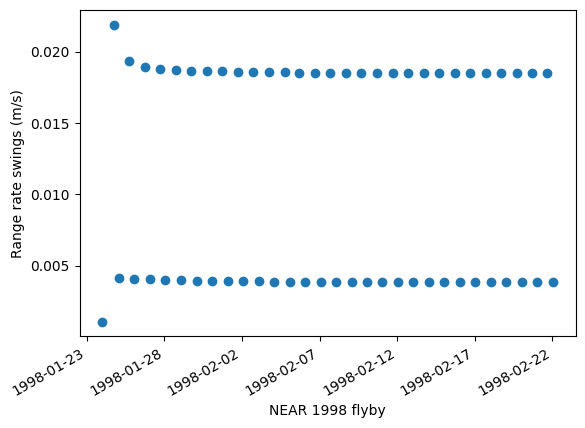

In [10]:
peak_epochs, peak_swings = find_swings(flyby_epochs, fitter.result.residual)
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('NEAR 1998 flyby')
    plt.ylabel('Range rate swings (m/s)')
    plt.scatter(peak_epochs, peak_swings)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()